In [1]:
#get some library
import pandas as pd
import seaborn as sns
from Bio import SeqIO
import numpy as np
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt
#import plotly.plotly as py
#from plotly import tools

from ipywidgets import widgets
from IPython.display import display
#from plotly.widgets import GraphWidget

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
#init_notebook_mode(connected=True)

In [2]:
#get only the gene id from
#the new TryTripDB format
def clean_id(temp_id):
    temp_id = temp_id.split(':')[0]
    if temp_id.count('.')>2:
        temp_id = '.'.join(temp_id.split('.')[0:3])
    return temp_id

#helper function to print out
#the protein removed at each threshold
def print_result(start_df_shape, shape_before, df, what):
    removed = shape_before[0]- df.shape[0]
    removed_from_beginning = start_df_shape[0]-df.shape[0]
    if removed > 0:
        print ('removed ',removed, what )  
        print ('tot ', removed_from_beginning, ' entries removed' )
        print ('---------------')
    else:
        print (what)
        print ('nothing removed')
        print ('---------------')

#remove rubbish entires from a
#maxquant output
def clean(df):  
    #remove Only identified by site
    before,start = df.shape,df.shape
    col = 'Only identified by site'
    df = df[df[col] != '+'] 
    print_result(start, before, df, col)
    
    #remove hits from reverse database
    before = df.shape
    col = 'Reverse'
    df = df[df[col] != '+']
    print_result(start, before, df, col)
        
    #remove contaminants (mainly keratine and bsa)
    before = df.shape
    col = 'Potential contaminant'
    df = df[df[col] != '+']
    print_result(start, before, df, col)
    
    ##remove protein groups with less thatn 2 unique peptides
    #before = df.shape
    #col = 'Peptide counts (unique)'
    #df['unique'] = [int(n.split(';')[0]) for n in df[col]]
    #df = df[df['unique'] >= 2]
    #print_result(start, before, df, col)
    return df

def quantileNormalize(df_input, keep_na=True):
    df = df_input.copy()
    #compute rank
    dic = {}
    for col in df:
        dic.update({col : sorted(df[col])})
    sorted_df = pd.DataFrame(dic)
    rank = sorted_df.mean(axis = 1).tolist()
    #sort
    for col in df:
        t = np.searchsorted(np.sort(df[col]), df[col])
        norm = [rank[i] for i in t]
        if keep_na == True:
            norm = [np.nan if np.isnan(a) else b for a,b in zip(df[col],norm)]
        df[col] =  norm             
    return df

In [3]:
#add back the description of the proteins
desc_dict = {}
path = '../PIG-A/TriTrypDB-46_TbruceiTREU927_AnnotatedProteins_VSG.fasta'
with open(path, "r") as handle:
    a=0
    for record in SeqIO.parse(handle, "fasta"):
        a+=1
        temp_id = clean_id(record.id).strip()
        temp_desc = record.description.split('|')[4].strip()
        #print  (record.description.split('|'))
        desc_dict[temp_id]=temp_desc


In [4]:
df = pd.read_csv('proteinGroups.txt',sep='\t')
df = clean(df)
df['Gene_id'] = [clean_id(n.split(';')[0]) for n in df['Protein IDs']]
df['Gene_desc'] = [desc_dict[n].split('=')[1].strip() for n in df['Gene_id']]
df.set_index('Gene_id',inplace=True)
df.head()


removed  23 Only identified by site
tot  23  entries removed
---------------
removed  21 Reverse
tot  44  entries removed
---------------
removed  42 Potential contaminant
tot  86  entries removed
---------------


,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Fasta headers,Number of proteins,Peptides,Razor + unique peptides,Unique peptides,...,id,Peptide IDs,Peptide is razor,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Oxidation (M) site positions,Gene_desc
Gene_id,,,,,,,,,,,,,,,,,,,,,
Tb927.11.17650,Tb927.11.17650:mRNA-p1,Tb927.11.17650:mRNA-p1,2,2,2,NaN,1,2,2,2,...,823,5106;6680,True;True,5573;7349,12972;12973;12974;12975;17117,14477;19078,14477;19078,NaN,NaN,"variant surface glycoprotein (VSG), frameshift..."
Tb927.3.2610,Tb927.3.2610:mRNA-p1,Tb927.3.2610:mRNA-p1,12,12,12,NaN,1,12,12,12,...,1178,498;2663;4579;5524;6121;6450;7216;7624;8057;80...,True;True;True;True;True;True;True;True;True;T...,526;2904;4979;4980;6012;6660;7010;8006;8456;89...,1338;6904;11555;11556;11557;11558;11559;13941;...,1581;7754;12943;12944;12945;12946;12947;12948;...,1581;7754;12947;15505;17255;18211;20988;22215;...,753;754,328;368,GPI inositol deacylase 2
Tb927.10.5820,Tb927.10.5820:mRNA-p1,Tb927.10.5820:mRNA-p1,12,12,12,NaN,1,12,12,12,...,544,1655;2393;3137;3368;3793;4094;6369;6918;7060;8...,True;True;True;True;True;True;True;True;True;T...,1795;1796;2603;3407;3659;4127;4452;6924;7680;7...,4330;4331;4332;6121;8063;8064;8606;8607;9674;9...,4934;4935;6880;9092;9704;9705;9706;10872;11604...,4935;6880;9092;9704;10872;11604;18029;20087;20...,386,417,predicted RanGDP binding protein
Tb927.7.1220,Tb927.7.1220:mRNA-p1,Tb927.7.1220:mRNA-p1,13,13,13,NaN,1,13,13,13,...,1593,20;901;1122;1919;2330;2804;3512;4143;6021;7197...,True;True;True;True;True;True;True;True;True;T...,21;968;1207;2085;2538;3055;3812;4504;6551;7986...,53;2416;2417;3019;5049;6001;7232;8953;10456;15...,62;2814;2815;3486;5701;6752;8102;8103;10077;11...,62;2815;3486;5701;6752;8103;10077;11713;16922;...,982,839,"hypothetical protein, conserved"
Tb927.6.1960,Tb927.6.1960:mRNA-p1,Tb927.6.1960:mRNA-p1,2,2,2,NaN,1,2,2,2,...,1492,5344;6173,True;True,5823;6713,13547;13548;15620,15087;15088;17391,15088;17391,NaN,NaN,"glycosyltransferase family 28 protein, putative"


In [6]:
list(df.columns)

['Protein IDs',
 'Majority protein IDs',
 'Peptide counts (all)',
 'Peptide counts (razor+unique)',
 'Peptide counts (unique)',
 'Fasta headers',
 'Number of proteins',
 'Peptides',
 'Razor + unique peptides',
 'Unique peptides',
 'Peptides DEAC2',
 'Peptides SM',
 'Razor + unique peptides DEAC2',
 'Razor + unique peptides SM',
 'Unique peptides DEAC2',
 'Unique peptides SM',
 'Sequence coverage [%]',
 'Unique + razor sequence coverage [%]',
 'Unique sequence coverage [%]',
 'Mol. weight [kDa]',
 'Sequence length',
 'Sequence lengths',
 'Fraction average',
 'Fraction 1',
 'Fraction 2',
 'Fraction 3',
 'Fraction 4',
 'Fraction 11',
 'Fraction 12',
 'Fraction 13',
 'Fraction 14',
 'Q-value',
 'Score',
 'Identification type DEAC2',
 'Identification type SM',
 'Sequence coverage DEAC2 [%]',
 'Sequence coverage SM [%]',
 'Intensity',
 'Intensity DEAC2',
 'Intensity SM',
 'iBAQ',
 'iBAQ DEAC2',
 'iBAQ SM',
 'LFQ intensity DEAC2',
 'LFQ intensity SM',
 'MS/MS count DEAC2',
 'MS/MS count SM',


In [7]:
df['Intensity DEAC2']=df['Intensity DEAC2']+df['Intensity DEAC2'][df['Intensity DEAC2']>0].min()
df['Intensity SM']=df['Intensity SM']+df['Intensity SM'][df['Intensity SM']>0].min()

df['iBAQ DEAC2']=df['iBAQ DEAC2']+df['iBAQ DEAC2'][df['iBAQ DEAC2']>0].min()
df['iBAQ SM']=df['iBAQ SM']+df['iBAQ SM'][df['iBAQ SM']>0].min()

df['LFQ intensity DEAC2']=df['LFQ intensity DEAC2']+df['LFQ intensity DEAC2'][df['LFQ intensity DEAC2']>0].min()
df['LFQ intensity SM']=df['LFQ intensity SM']+df['LFQ intensity SM'][df['LFQ intensity SM']>0].min()

In [9]:
df['fc2']= df['iBAQ DEAC2']/df['iBAQ SM']
df['log10_score'] = np.log10(df['Score'])
df['log10_intensity'] = np.log10(df['Intensity'])
df['log10_iBAQ'] = np.log10(df['iBAQ'])

In [36]:
df[(df['fc2_log']>2)].shape


(465, 67)

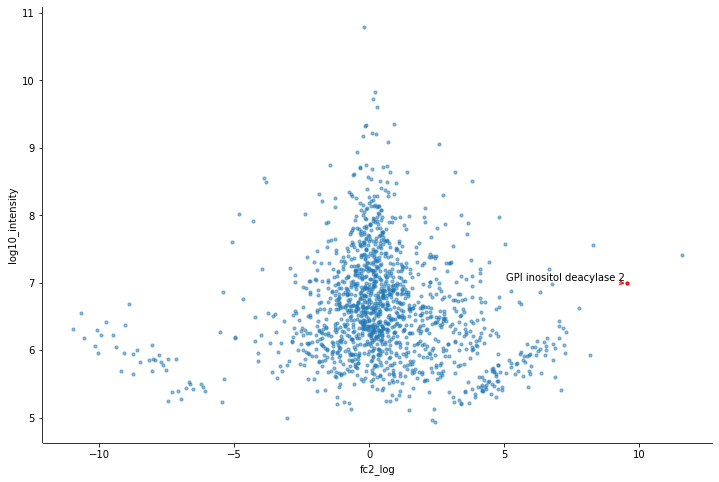

In [33]:
from adjustText import adjust_text
df['fc2_log']=np.log2(df['fc2'])
df['log10_score']=np.log2(df['Score'])

selection = df[df['Score']>15]
fig,ax = plt.subplots(figsize=(12,8))
sns.regplot(x='fc2_log', y='log10_intensity', 
            fit_reg=False, data = selection,
            ax=ax, scatter_kws={'s':10,'alpha':0.5})
sns.despine(offset=1, trim=False)


select = df[(df['fc2_log']>5)&(df['log10_intensity']>6.5)]
#select.plot(x='log_mean', y='log10_intensity',kind='scatter', c='r', ax=ax)
select = df[(df['Protein IDs'].str.contains('Tb927.3.2610')) ]




sns.regplot(x='fc2_log', y='log10_intensity', 
            fit_reg=False, data = select,
            ax=ax, scatter_kws={'s':10,'color':'red'})


texts = [plt.text(select.loc[i]['fc2_log'], 
                  select.loc[i]['log10_intensity'], 
                  select.loc[i]['Gene_desc'].split(',')[0][0:30]
                 ) for i in select.index.values]

adjust_text(texts, 
            arrowprops=dict(arrowstyle='->',
                            color='red'))

df[df['Protein IDs'].str.contains('Tb927.11.17650')].plot(kind='scatter',
                                                          x='fc2_log', 
                                                          y='log10_intensity',ax=ax,
                                                         alpha=0.5,s=10)

#x = selection.loc[['Tb927.11.12080']]['log_mean']
#y= selection.loc[['Tb927.11.12080']]['log10_intensity']
#ax.annotate('Bait',(x,y), xytext=(x+0.01,y))

#x = selection.loc[['Tb927.10.9860']]['fc']
#y= selection.loc[['Tb927.10.9860']]['log10_score']
#ax.annotate('MTQ1, putative',(x,y),xytext=(x+0.01,y))

#x = selection.loc[['Tb927.11.15990']]['fc']
#y= selection.loc[['Tb927.11.15990']]['log10_score']
#ax.annotate('NUP109',(x,y),xytext=(x+0.01,y))

#x = selection.loc[['Tb927.10.7100']]['fc']
#y= selection.loc[['Tb927.10.7100']]['log10_score']
#ax.annotate('Tb927.10.7100',(x,y),xytext=(x+0.01,y))

#x = selection.loc[['Tb927.11.12500']]['fc']
#y= selection.loc[['Tb927.11.12500']]['log10_score']
#ax.annotate('Tb927.11.12500',(x,y),xytext=(x+0.01,y))




#ax.set_xlabel('Sum Intensity / Bait Intensity')
#ax.set_ylabel('Log10 Score')
plt.savefig('Fig1.svg')
plt.savefig('Fig1.png')
plt.show()

In [40]:
df[(df['fc2_log']>2)][['Protein IDs','Gene_desc','iBAQ DEAC2','iBAQ SM','fc2_log','log10_intensity']
                     ].to_csv('table.csv')
                                                                                                            